# Soil Classification with Conditional GAN Data Augmentation
This notebook uses a Conditional GAN (cGAN) to generate synthetic soil images for data augmentation, then trains a CNN classifier on the augmented dataset.

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import math
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import timm

# Add src to path to import utils
sys.path.insert(0, str(Path('..') / 'src'))
from utils import load_parameters, load_and_pre_process_images
from visualization import show_soil_grid

## Data Collection & Preprocessing

In [8]:
# Load parameters from txt file
params_path = Path('..') / 'txt' / 'parameters.txt'
params = load_parameters(params_path)

# Extract parameters
soil_types = params['SOIL_TYPES'].split(',')
TRAIN_RATIO = params['TRAIN_RATIO']
VAL_RATIO = params['VAL_RATIO']
TEST_RATIO = params['TEST_RATIO']
BATCH_SIZE = int(params['BATCH_SIZE'])
SEED = int(params['SEED'])
LEARNING_RATE = params['LEARNING_RATE']
NUM_EPOCHS_GAN = int(params['EPOCHS'])

# Setup data paths
root_dir = '..'
data_dir = Path(root_dir) / 'data'
images_dir = data_dir / 'Orignal-Dataset'

print(f"\nLoading images for {len(soil_types)} soil types...\n")

# Load images using utils function (handles resize/crop and non-JPG conversion)
images_dict = {}
for soil_type in soil_types:
    folder_path = images_dir / soil_type
    images = load_and_pre_process_images(folder_path, 256)
    images_dict[soil_type] = images
    print(f"{soil_type}: {len(images)} images loaded")


Loaded parameters:
  TRAIN_RATIO = 0.7
  VAL_RATIO = 0.1
  TEST_RATIO = 0.2
  BATCH_SIZE = 64
  EPOCHS = 100
  LEARNING_RATE = 0.01
  SEED = 42
  lr = 0.0001
  dropout = 0.3
  weight_decay = 0.0001
  SOIL_TYPES = Alluvial_Soil,Arid_Soil,Black_Soil,Laterite_Soil,Mountain_Soil,Red_Soil,Yellow_Soil

Loading images for 7 soil types...

Alluvial_Soil: 52 images loaded
Arid_Soil: 284 images loaded
Black_Soil: 255 images loaded
Laterite_Soil: 219 images loaded
Mountain_Soil: 201 images loaded
Red_Soil: 109 images loaded
Yellow_Soil: 69 images loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0590332..4.995021].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0451112..2.1259637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9677533..4.3660645].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.283933..3.2710366].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9346344..2.9974468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.751741..3.7859335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4708412..

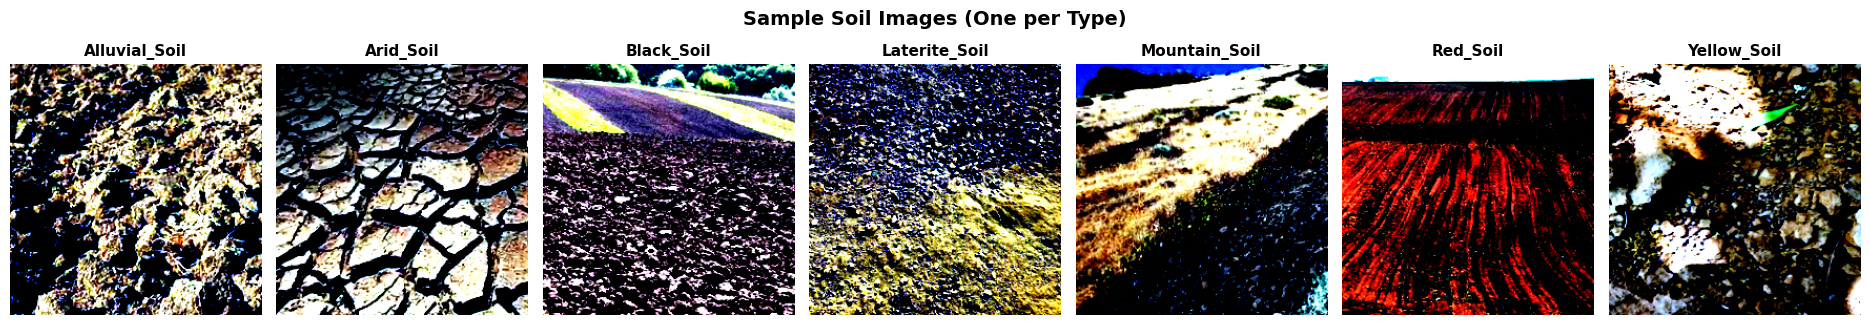

In [9]:
# Visualize sample images from each soil type using visualization function
show_soil_grid(images_dict, n_per_type=5, tile_size=(240, 240), pad=12)

In [10]:
# No additional standardization step here; preprocessing handled in utils load_and_pre_process_images
standardized_images_dict = images_dict

## Train/test/val split

In [ ]:
all_images = []
all_labels = []
for soil_type, images in images_dict.items():
    for img, filename in images:
        all_images.append(img)
        all_labels.append(soil_type)

if not all_images:
    raise RuntimeError(
        f"No images were loaded from {images_dir}. "
        "Verify the dataset path and make sure each soil folder contains image files."
    )

label_counts = Counter(all_labels)
can_stratify = len(label_counts) > 1 and min(label_counts.values()) >= 2
if not can_stratify:
    warnings.warn(
        "Insufficient samples per class for a stratified split; falling back to an unstratified split.",
        RuntimeWarning,
    )

stratify_all = all_labels if can_stratify else None

X_temp, X_test, y_temp, y_test = train_test_split(
    all_images,
    all_labels,
    test_size=TEST_RATIO,
    random_state=SEED,
    stratify=stratify_all,
)

relative_val_ratio = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)

if stratify_all:
    temp_counts = Counter(y_temp)
    can_stratify_val = len(temp_counts) > 1 and min(temp_counts.values()) >= 2
    if not can_stratify_val:
        warnings.warn(
            "Validation split cannot be stratified due to limited samples; using a random split instead.",
            RuntimeWarning,
        )
    stratify_val = y_temp if can_stratify_val else None
else:
    stratify_val = None

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=relative_val_ratio,
    random_state=SEED,
    stratify=stratify_val,
)

print(f"Dataset split: train ({len(X_train)}), val ({len(X_val)}), test ({len(X_test)})")

Dataset split: train (832), val (119), test (238)


In [12]:
class SoilDataset(Dataset):
    def __init__(self, images, labels):
        self.data = images
        self.labels = labels
        unique_labels = sorted(list(set(labels)))
        self.soil_type_to_idx = {soil_type: idx for idx, soil_type in enumerate(unique_labels)}
        self.label_indices = [self.soil_type_to_idx[label] for label in labels]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        img = np.transpose(img, (2, 0, 1))
        img_tensor = torch.FloatTensor(img)
        label = self.label_indices[idx]
        return img_tensor, label

train_dataset = SoilDataset(X_train, y_train)
val_dataset = SoilDataset(X_val, y_val)
test_dataset = SoilDataset(X_test, y_test)
print(f"Datasets created - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Datasets created - Train: 832, Val: 119, Test: 238


## Conditional GAN Models

In [13]:
class Generator(nn.Module):
    """Conditional Generator: generates soil images for specific classes"""
    def __init__(self, latent_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_shape = img_shape
        
        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(2 * latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        label_embedding = self.label_embedding(labels)
        z_label = torch.cat([z, label_embedding], dim=1)
        img = self.model(z_label)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [14]:
class Discriminator(nn.Module):
    """Conditional Discriminator: validates authenticity and classifies soil type"""
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()
        self.img_shape = img_shape
        self.num_classes = num_classes
        
        self.label_embedding = nn.Embedding(num_classes, int(np.prod(img_shape)))
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) * 2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.validity = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.classification = nn.Sequential(
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        label_embedding = self.label_embedding(labels)
        img_label = torch.cat([img_flat, label_embedding], dim=1)
        features = self.model(img_label)
        validity = self.validity(features)
        classification = self.classification(features)
        return validity, classification

## Training Setup

In [15]:
BATCH_SIZE = 64
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 0.0002
BETA_1 = 0.5
BETA_2 = 0.999
NUM_EPOCHS_GAN = 100

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device(DEVICE)

latent_dim = 100
img_shape = (3, 128, 128)
num_classes = len(soil_types)

print(f"Device: {DEVICE}")
print(f"Classes: {num_classes} soil types")

Device: cuda
Classes: 7 soil types


In [16]:
generator = Generator(latent_dim, num_classes, img_shape).to(device)
discriminator = Discriminator(num_classes, img_shape).to(device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))

criterion_adversarial = nn.BCELoss()
criterion_classification = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Models initialized and optimizers created")

Models initialized and optimizers created


## Train Conditional GAN

In [17]:
print("Starting cGAN training...\n")

for epoch in range(NUM_EPOCHS_GAN):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size = imgs.size(0)
        
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)
        
        # Train Discriminator
        optimizer_d.zero_grad()
        
        validity_real, class_real = discriminator(imgs, labels)
        d_loss_real = criterion_adversarial(validity_real, valid)
        d_loss_class_real = criterion_classification(class_real, labels)
        
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z, labels)
        validity_fake, class_fake = discriminator(gen_imgs.detach(), labels)
        d_loss_fake = criterion_adversarial(validity_fake, fake)
        d_loss_class_fake = criterion_classification(class_fake, labels)
        
        d_loss = (d_loss_real + d_loss_fake) / 2 + (d_loss_class_real + d_loss_class_fake) / 2
        d_loss.backward()
        optimizer_d.step()
        
        # Train Generator
        optimizer_g.zero_grad()
        
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z, labels)
        validity_gen, class_gen = discriminator(gen_imgs, labels)
        
        g_loss_adv = criterion_adversarial(validity_gen, valid)
        g_loss_class = criterion_classification(class_gen, labels)
        g_loss = g_loss_adv + g_loss_class
        
        g_loss.backward()
        optimizer_g.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"[Epoch {epoch+1}/{NUM_EPOCHS_GAN}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("\ncGAN training completed!")

Starting cGAN training...



RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x245760 and 98304x512)

## Generate Synthetic Images

In [ ]:
print("Generating synthetic images for data augmentation...\n")

generator.eval()
num_synthetic_per_class = 50
synthetic_images_dict = {}

with torch.no_grad():
    for class_idx, soil_type in enumerate(soil_types):
        synthetic_images = []
        for _ in range(num_synthetic_per_class):
            z = torch.randn(1, latent_dim, device=device)
            class_label = torch.tensor([class_idx], device=device)
            gen_img = generator(z, class_label)
            gen_img_np = gen_img.squeeze(0).cpu().numpy()
            gen_img_np = np.transpose(gen_img_np, (1, 2, 0))
            synthetic_images.append(gen_img_np)
        synthetic_images_dict[soil_type] = synthetic_images
        print(f"Generated {len(synthetic_images)} synthetic images for {soil_type}")

total_synthetic = sum(len(imgs) for imgs in synthetic_images_dict.values())
print(f"\nTotal synthetic images: {total_synthetic}")

Generating synthetic images for data augmentation...

Generated 50 synthetic images for Alluvial_Soil
Generated 50 synthetic images for Arid_Soil
Generated 50 synthetic images for Black_Soil
Generated 50 synthetic images for Laterite_Soil
Generated 50 synthetic images for Mountain_Soil
Generated 50 synthetic images for Red_Soil
Generated 50 synthetic images for Yellow_Soil

Total synthetic images: 350


Visualizing synthetic images...



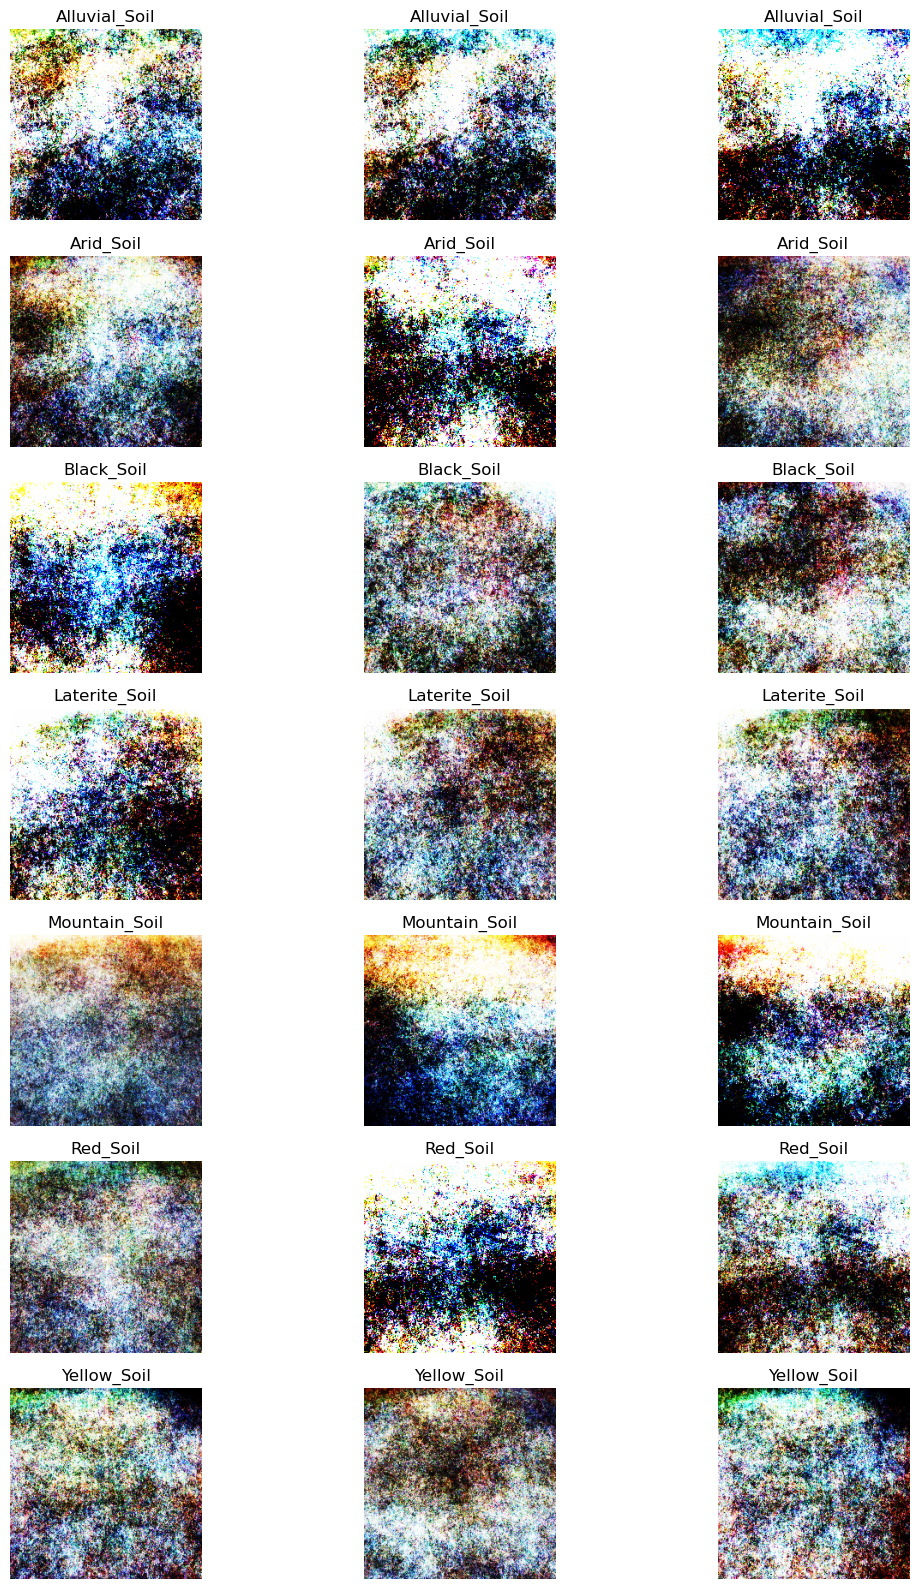

In [ ]:
print("Visualizing synthetic images...\n")

fig, axes = plt.subplots(7, 3, figsize=(12, 16))
for class_idx, soil_type in enumerate(soil_types):
    for img_idx in range(3):
        ax = axes[class_idx, img_idx]
        img = synthetic_images_dict[soil_type][img_idx]
        img_display = np.clip((img + 1) / 2, 0, 1)
        ax.imshow(img_display)
        ax.set_title(f"{soil_type}")
        ax.axis('off')
plt.tight_layout()
plt.show()

## Create Augmented Dataset

In [ ]:
# Class Equalizer: Balance classes by generating synthetic images for underrepresented classes
print("="*70)
print("CLASS EQUALIZER: Balancing Dataset")
print("="*70)

# Count original training images per class (from the preprocessed images)
original_counts = {soil_type: len(images_dict.get(soil_type, [])) for soil_type in soil_types}

print("\nOriginal Training Distribution:")
for soil_type in soil_types:
    print(f"  {soil_type}: {original_counts[soil_type]} images")

# Find the maximum count
max_count = max(original_counts.values())
print(f"\nMaximum images per class (target): {max_count}")

# Start with original training images
augmented_images = X_train.copy()
augmented_labels = y_train.copy()

# Generate additional synthetic images for underrepresented classes
print("\nEqualization Plan:")
total_generated = 0
for soil_type, synthetic_imgs in synthetic_images_dict.items():
    current_count = original_counts[soil_type]
    images_needed = max_count - current_count
    
    if images_needed > 0:
        # Use only the needed synthetic images (or cycle through if not enough)
        synthetic_to_add = (synthetic_imgs * (images_needed // len(synthetic_imgs) + 1))[:images_needed]
        augmented_images.extend(synthetic_to_add)
        augmented_labels.extend([soil_type] * len(synthetic_to_add))
        total_generated += len(synthetic_to_add)
        print(f"  {soil_type}: +{len(synthetic_to_add)} synthetic images ({current_count} → {current_count + len(synthetic_to_add)})")
    else:
        print(f"  {soil_type}: Already balanced ({current_count} images)")

# Verify final class distribution
final_counts = Counter(augmented_labels)
print("\nFinal Distribution (After Equalization):")
for soil_type in soil_types:
    count = final_counts.get(soil_type, 0)
    print(f"  {soil_type}: {count} images")

print("\n" + "="*70)
print(f"Original training set size: {len(X_train)}")
print(f"Synthetic images added: {total_generated}")
print(f"Augmented training set size: {len(augmented_images)}")
print(f"Augmentation ratio: {len(augmented_images) / len(X_train):.2f}x")
print("="*70)

# Create balanced dataset without class weights - all classes treated equally
augmented_dataset = SoilDataset(augmented_images, augmented_labels)
augmented_train_loader = torch.utils.data.DataLoader(
    augmented_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
 )

print(f"\nBalanced DataLoader ready with {len(augmented_dataset)} samples")

Original training set size: 831
Synthetic images added: 350
Augmented training set size: 1181
Augmentation ratio: 1.42x
Augmented class counts:
  Alluvial_Soil: 86
  Arid_Soil: 249
  Black_Soil: 228
  Laterite_Soil: 203
  Mountain_Soil: 191
  Red_Soil: 126
  Yellow_Soil: 98

Augmented DataLoader ready with 1181 samples


## CNN Classifier

In [ ]:
class SoilClassifier(nn.Module):
    """CNN for soil type classification"""
    def __init__(self, num_classes):
        super(SoilClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Input is now 128x128 -> 64 -> 32 -> 16 -> 8, so 256*8*8
        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

classifier = SoilClassifier(num_classes).to(device)
print(f"Classifier model created with {num_classes} output classes")

Classifier model created with 7 output classes


In [ ]:
print("\nTraining classifier on balanced augmented data...\n")

classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
# Use standard CrossEntropyLoss - no class weights needed since dataset is now balanced
classifier_criterion = nn.CrossEntropyLoss()
num_epochs_classifier = 50

classifier.train()
for epoch in range(num_epochs_classifier):
    total_loss = 0
    correct = 0
    total = 0
    
    for imgs, labels in augmented_train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        classifier_optimizer.zero_grad()
        outputs = classifier(imgs)
        loss = classifier_criterion(outputs, labels)
        loss.backward()
        classifier_optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(augmented_train_loader)
    train_acc = 100 * correct / total
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs_classifier} - Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%")

print("\nClassifier training completed!")


Training classifier on augmented data...

Epoch 10/50 - Loss: 0.6621, Accuracy: 70.36%
Epoch 20/50 - Loss: 0.1623, Accuracy: 92.89%
Epoch 30/50 - Loss: 0.0723, Accuracy: 97.54%
Epoch 40/50 - Loss: 0.0494, Accuracy: 97.12%
Epoch 50/50 - Loss: 0.0551, Accuracy: 98.14%

Classifier training completed!


## Evaluate on Test Set

In [ ]:
print("\nEvaluating classifier on test set...\n")

classifier.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = classifier(imgs)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_true_labels, all_predictions, average='weighted', zero_division=0)

print("=" * 50)
print("TEST SET RESULTS - CNN with cGAN Augmentation")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 50)


Evaluating classifier on test set...

TEST SET RESULTS - CNN with cGAN Augmentation
Accuracy:  0.5336 (53.36%)
Precision: 0.5471
Recall:    0.5336
F1-Score:  0.5340


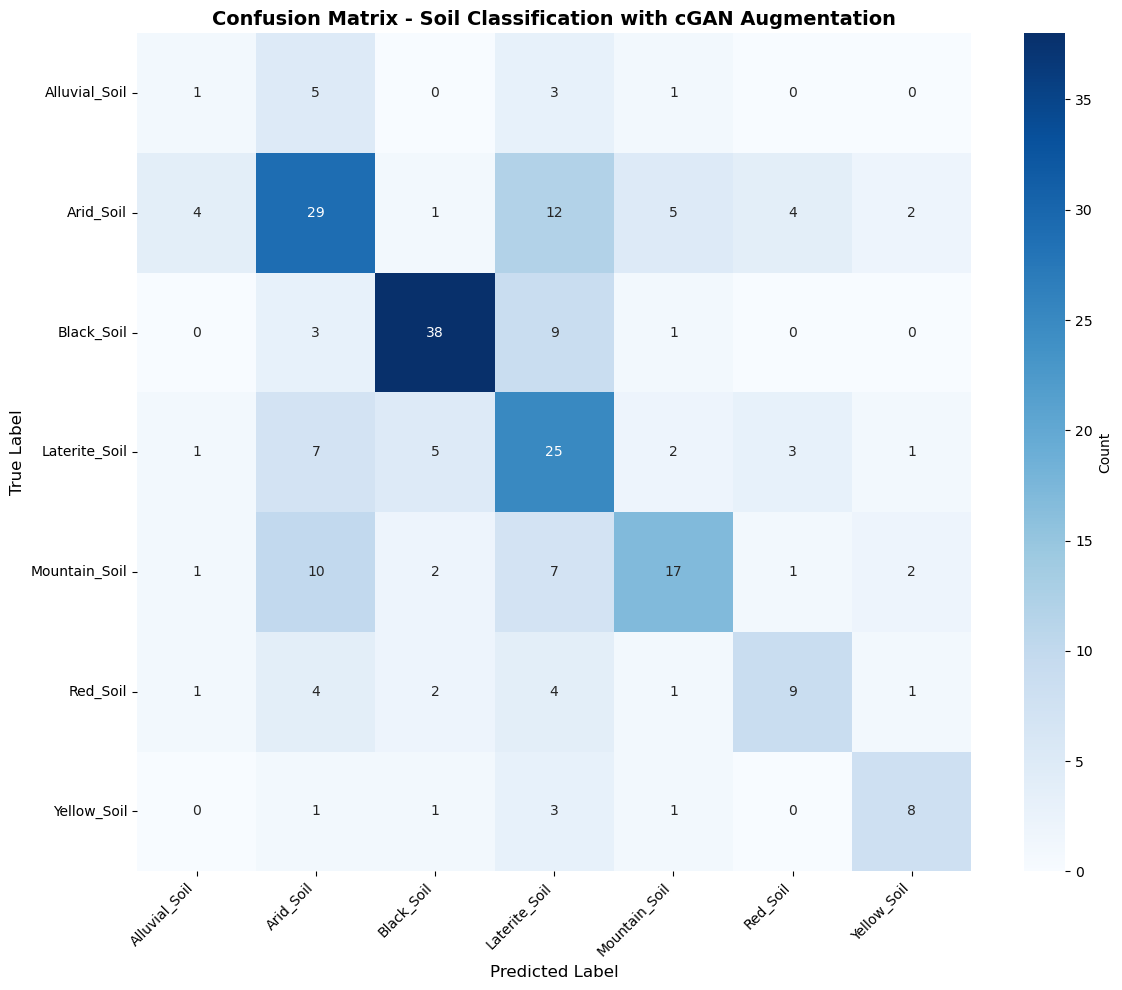

In [ ]:
cm = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Soil Classification with cGAN Augmentation', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

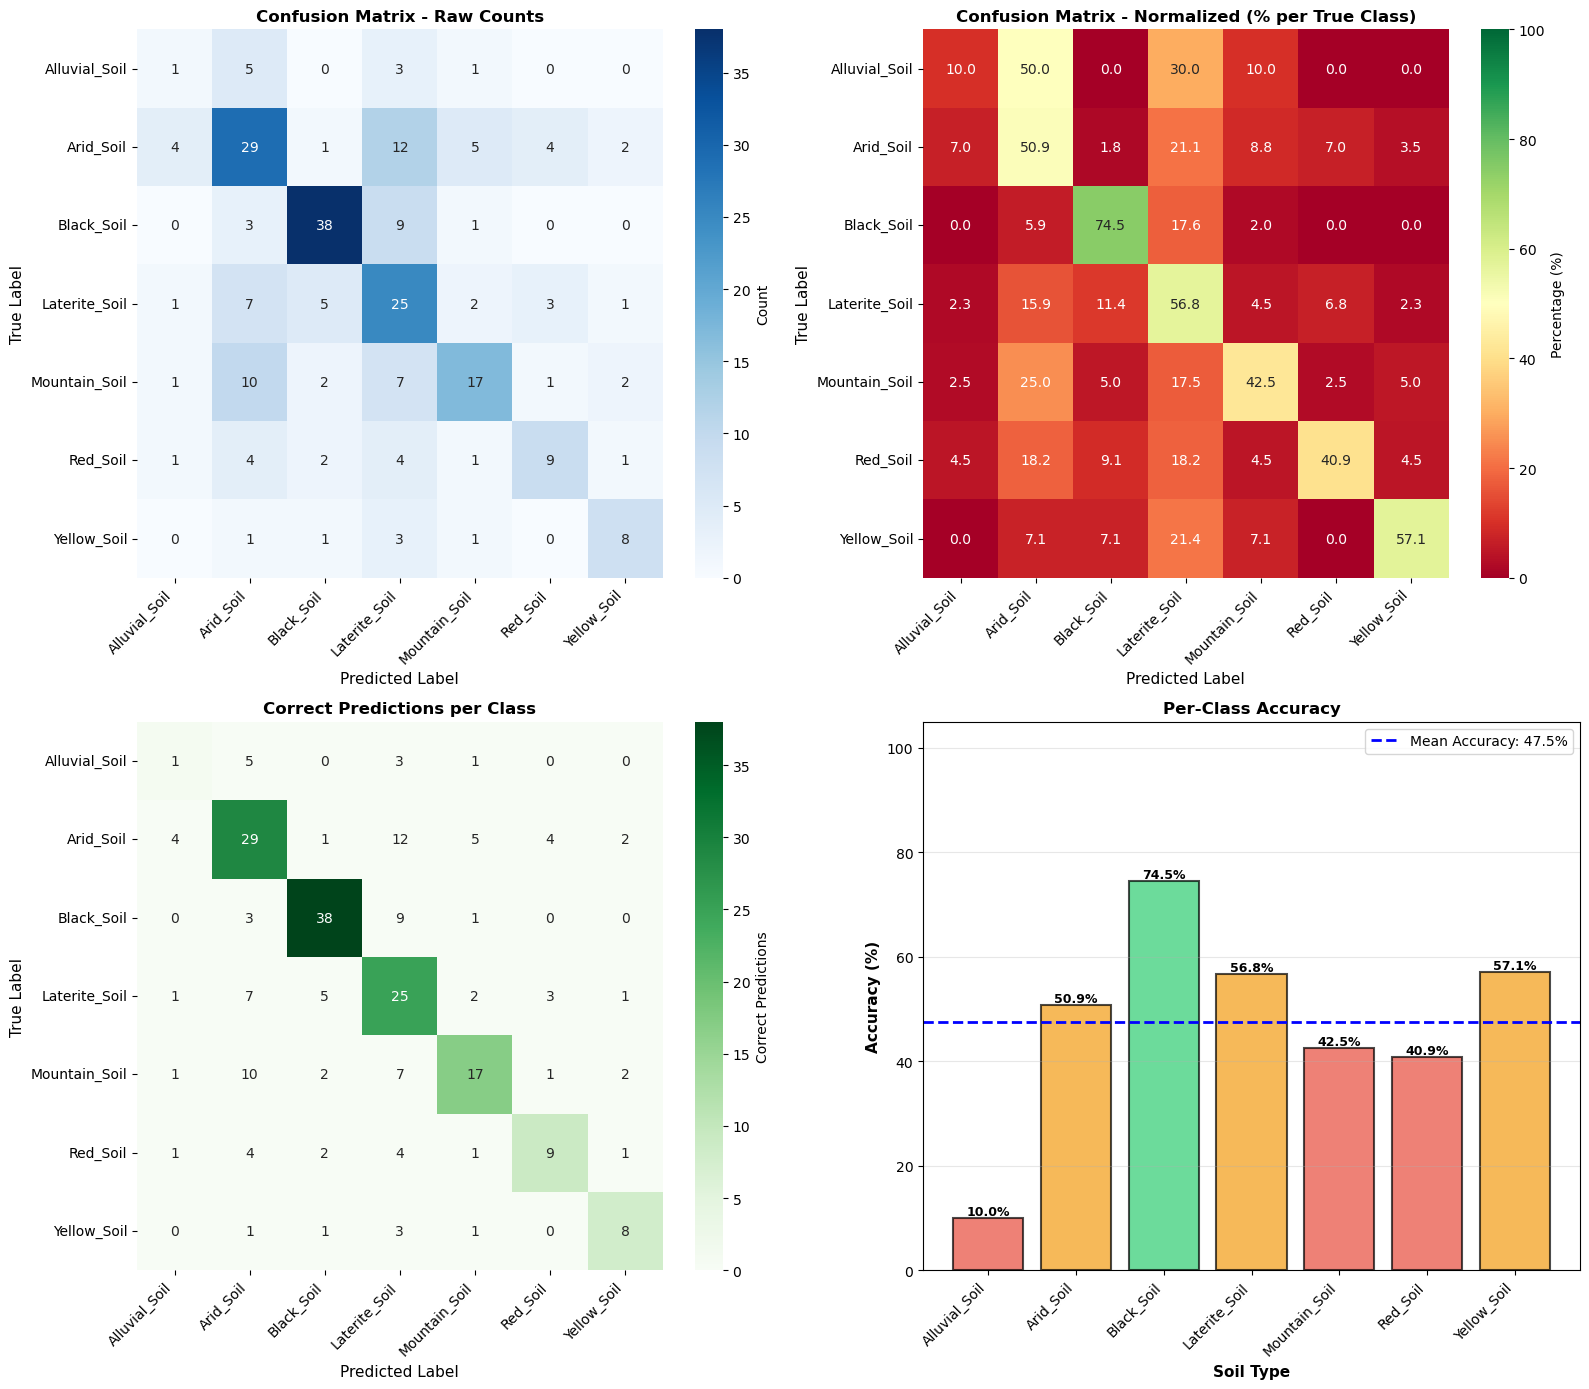


DETAILED ACCURACY ANALYSIS
Alluvial_Soil       :   1/ 10 =  10.00%
Arid_Soil           :  29/ 57 =  50.88%
Black_Soil          :  38/ 51 =  74.51%
Laterite_Soil       :  25/ 44 =  56.82%
Mountain_Soil       :  17/ 40 =  42.50%
Red_Soil            :   9/ 22 =  40.91%
Yellow_Soil         :   8/ 14 =  57.14%


In [ ]:
# Enhanced Confusion Matrix Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Raw Confusion Matrix (Counts)
ax = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Count'})
ax.set_title('Confusion Matrix - Raw Counts', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# 2. Normalized Confusion Matrix (Percentages by True Class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
ax = axes[0, 1]
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100)
ax.set_title('Confusion Matrix - Normalized (% per True Class)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# 3. Correct Predictions Heatmap (Diagonal Only)
cm_correct = np.zeros_like(cm, dtype=float)
for i in range(len(soil_types)):
    cm_correct[i, i] = cm[i, i]
    
ax = axes[1, 0]
sns.heatmap(cm_correct, annot=cm, fmt='d', cmap='Greens', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Correct Predictions'})
ax.set_title('Correct Predictions per Class', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# 4. Per-Class Accuracy Bar Chart
class_accuracies = np.diag(cm) / cm.sum(axis=1) * 100
colors = ['#2ecc71' if acc >= 70 else '#f39c12' if acc >= 50 else '#e74c3c' for acc in class_accuracies]
ax = axes[1, 1]
bars = ax.bar(soil_types, class_accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(y=np.mean(class_accuracies), color='blue', linestyle='--', linewidth=2, label=f'Mean Accuracy: {np.mean(class_accuracies):.1f}%')
ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax.set_xlabel('Soil Type', fontsize=11, fontweight='bold')
ax.set_title('Per-Class Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim([0, 105])
ax.set_xticklabels(soil_types, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed accuracy summary
print("\n" + "="*70)
print("DETAILED ACCURACY ANALYSIS")
print("="*70)
for i, soil_type in enumerate(soil_types):
    correct = cm[i, i]
    total = cm[i].sum()
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"{soil_type:20s}: {correct:3d}/{total:3d} = {accuracy:6.2f}%")
print("="*70)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    all_true_labels, all_predictions, average=None, zero_division=0
)

print("\nPer-Class Metrics:")
print("=" * 70)
print(f"{'Soil Type':<20} {'Precision':<15} {'Recall':<15} {'F1-Score':<15}")
print("=" * 70)
for i, soil_type in enumerate(soil_types):
    print(f"{soil_type:<20} {precision_per_class[i]:<15.4f} {recall_per_class[i]:<15.4f} {f1_per_class[i]:<15.4f}")
print("=" * 70)


Per-Class Metrics:
Soil Type            Precision       Recall          F1-Score       
Alluvial_Soil        0.1250          0.1000          0.1111         
Arid_Soil            0.4915          0.5088          0.5000         
Black_Soil           0.7755          0.7451          0.7600         
Laterite_Soil        0.3968          0.5682          0.4673         
Mountain_Soil        0.6071          0.4250          0.5000         
Red_Soil             0.5294          0.4091          0.4615         
Yellow_Soil          0.5714          0.5714          0.5714         



Saving results to GAN folder...



NameError: name 'cm' is not defined

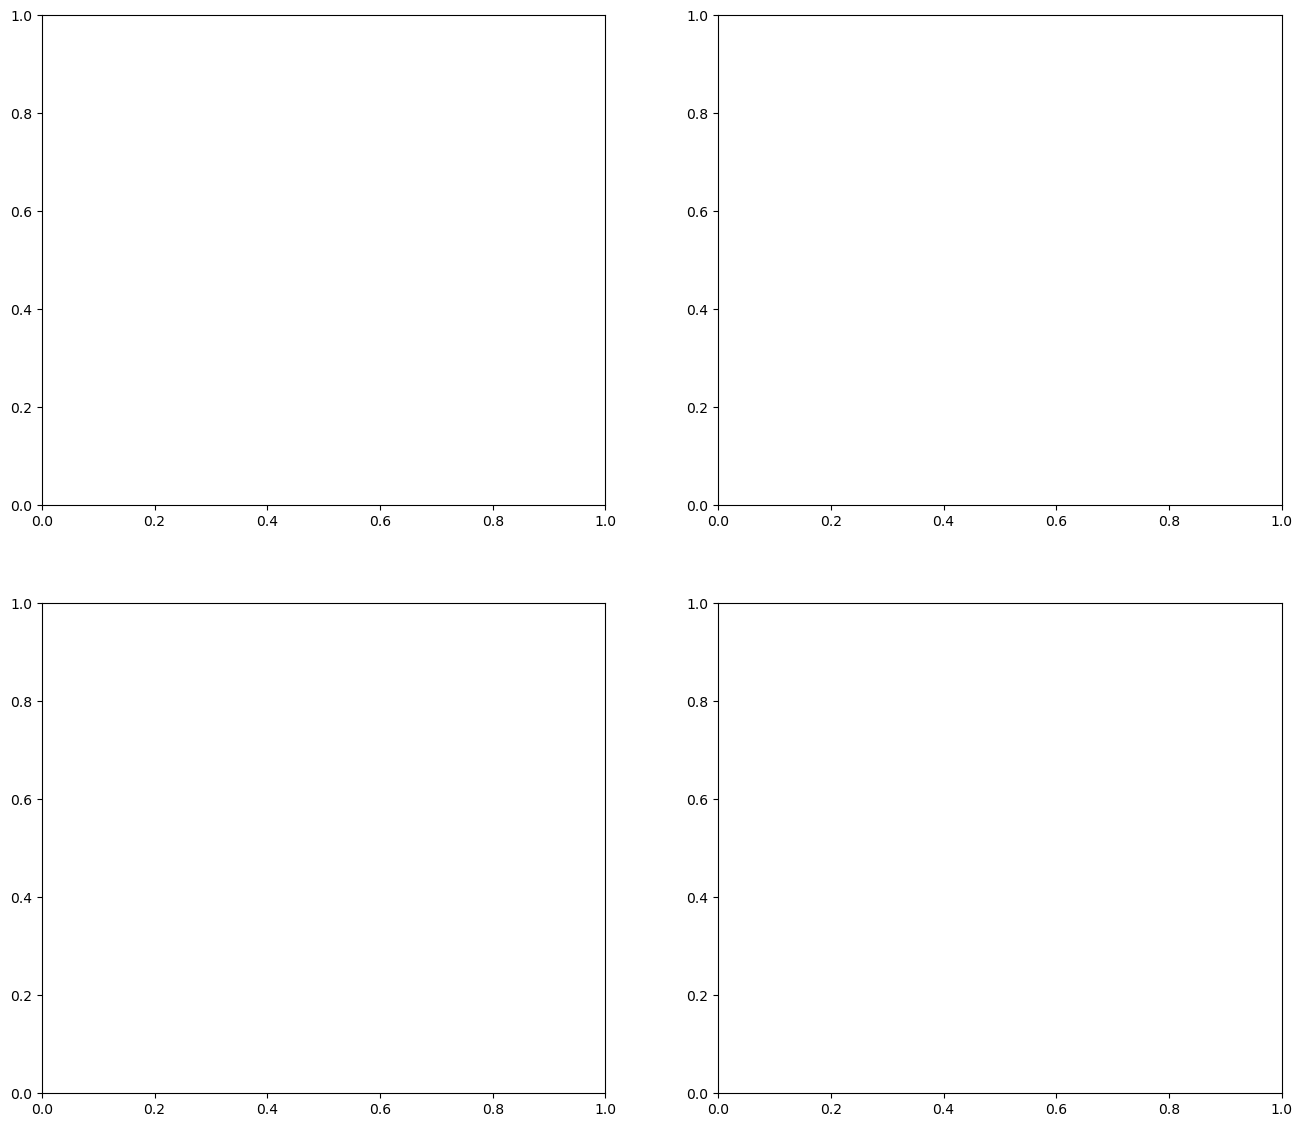

In [ ]:
# Save results to GAN folder
print("\nSaving results to GAN folder...\n")

results_dir = Path('..') / 'results' / 'GAN'
results_dir.mkdir(parents=True, exist_ok=True)

# Save confusion matrix as image
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Raw Confusion Matrix (Counts)
ax = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Count'})
ax.set_title('Confusion Matrix - Raw Counts', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# 2. Normalized Confusion Matrix (Percentages by True Class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
ax = axes[0, 1]
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100)
ax.set_title('Confusion Matrix - Normalized (% per True Class)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# 3. Correct Predictions Heatmap (Diagonal Only)
cm_correct = np.zeros_like(cm, dtype=float)
for i in range(len(soil_types)):
    cm_correct[i, i] = cm[i, i]
    
ax = axes[1, 0]
sns.heatmap(cm_correct, annot=cm, fmt='d', cmap='Greens', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Correct Predictions'})
ax.set_title('Correct Predictions per Class', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# 4. Per-Class Accuracy Bar Chart
class_accuracies = np.diag(cm) / cm.sum(axis=1) * 100
colors = ['#2ecc71' if acc >= 70 else '#f39c12' if acc >= 50 else '#e74c3c' for acc in class_accuracies]
ax = axes[1, 1]
bars = ax.bar(soil_types, class_accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(y=np.mean(class_accuracies), color='blue', linestyle='--', linewidth=2, label=f'Mean Accuracy: {np.mean(class_accuracies):.1f}%')
ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax.set_xlabel('Soil Type', fontsize=11, fontweight='bold')
ax.set_title('Per-Class Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim([0, 105])
ax.set_xticklabels(soil_types, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(results_dir / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
print(f"Confusion matrices saved to {results_dir / 'confusion_matrices.png'}")

# Save metrics to CSV
metrics_df = pd.DataFrame({
    'Soil Type': soil_types,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Correct': np.diag(cm),
    'Total': cm.sum(axis=1),
    'Accuracy (%)': class_accuracies
})
metrics_df.to_csv(results_dir / 'per_class_metrics.csv', index=False)
print(f"Per-class metrics saved to {results_dir / 'per_class_metrics.csv'}")

# Save overall metrics to text file
with open(results_dir / 'overall_metrics.txt', 'w') as f:
    f.write("=" * 50 + "\\n")
    f.write("TEST SET RESULTS - CNN with cGAN Augmentation\\n")
    f.write("=" * 50 + "\\n\\n")
    f.write(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)\\n")
    f.write(f"Precision: {precision:.4f}\\n")
    f.write(f"Recall:    {recall:.4f}\\n")
    f.write(f"F1-Score:  {f1:.4f}\\n")
    f.write("\\n" + "=" * 50 + "\\n")
    f.write("DETAILED ACCURACY ANALYSIS\\n")
    f.write("=" * 50 + "\\n\\n")
    for i, soil_type in enumerate(soil_types):
        correct = cm[i, i]
        total = cm[i].sum()
        acc = (correct / total * 100) if total > 0 else 0
        f.write(f"{soil_type:20s}: {correct:3d}/{total:3d} = {acc:6.2f}%\\n")

print(f"Overall metrics saved to {results_dir / 'overall_metrics.txt'}")

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=soil_types, columns=soil_types)
cm_df.to_csv(results_dir / 'confusion_matrix.csv')
print(f"Confusion matrix saved to {results_dir / 'confusion_matrix.csv'}")

print(f"\nAll results saved to {results_dir}")


## Evaluation with Transformer Architecture

In [ ]:
# Load Transformer Model from checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

transformer_model_path = Path('..') / 'models' / 'best_model_transformer'

if transformer_model_path.exists():
    print(f"\nLoading transformer model from {transformer_model_path}")
    
    # Create the Swin Transformer model
    transformer_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=len(soil_types))
    
    # Load checkpoint
    checkpoint = torch.load(transformer_model_path, map_location=device)
    transformer_model.load_state_dict(checkpoint['model_state_dict'])
    transformer_model.to(device)
    transformer_model.eval()
    
    print("Transformer model loaded successfully!")
    print(f"Model was trained for {checkpoint.get('epoch', 'unknown')} epochs")
else:
    print(f"Transformer model not found at {transformer_model_path}")
    print("Please train the transformer model first using '1. Transformer Attention Mechanism.ipynb'")

In [ ]:
# Prepare data for Transformer (needs 224x224 images with normalization)
from torchvision import transforms

# Define transforms for Swin Transformer (needs 224x224)
transformer_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class TransformerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.data = images
        self.labels = labels
        self.transform = transform
        unique_labels = sorted(list(set(labels)))
        self.soil_type_to_idx = {soil_type: idx for idx, soil_type in enumerate(unique_labels)}
        self.label_indices = [self.soil_type_to_idx[label] for label in labels]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        
        # Convert from BGR to RGB and uint8
        if img.dtype == np.float32:
            img = (img * 255).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        
        label = self.label_indices[idx]
        return img, label

# Create transformer test dataset
transformer_test_dataset = TransformerDataset(X_test, y_test, transform=transformer_transform)
transformer_test_loader = DataLoader(transformer_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Transformer test dataset created with {len(transformer_test_dataset)} images")

In [ ]:
# Evaluate Transformer on test set
if transformer_model_path.exists():
    print("Evaluating Transformer model on test set...")
    
    transformer_predictions = []
    transformer_true_labels = []
    
    with torch.no_grad():
        for images, labels in transformer_test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = transformer_model(images)
            _, predicted = torch.max(outputs, 1)
            
            transformer_predictions.extend(predicted.cpu().numpy())
            transformer_true_labels.extend(labels.cpu().numpy())
    
    transformer_predictions = np.array(transformer_predictions)
    transformer_true_labels = np.array(transformer_true_labels)
    
    # Calculate metrics
    transformer_accuracy = accuracy_score(transformer_true_labels, transformer_predictions)
    transformer_precision = precision_score(transformer_true_labels, transformer_predictions, average='weighted', zero_division=0)
    transformer_recall = recall_score(transformer_true_labels, transformer_predictions, average='weighted', zero_division=0)
    transformer_f1 = f1_score(transformer_true_labels, transformer_predictions, average='weighted', zero_division=0)
    
    print(f"\nTransformer Model Performance:")
    print(f"Accuracy:  {transformer_accuracy:.4f}")
    print(f"Precision: {transformer_precision:.4f}")
    print(f"Recall:    {transformer_recall:.4f}")
    print(f"F1-Score:  {transformer_f1:.4f}")
else:
    print("Transformer model not available for evaluation")

In [ ]:
# Plot Transformer Confusion Matrix
if transformer_model_path.exists():
    transformer_cm = confusion_matrix(transformer_true_labels, transformer_predictions)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Confusion Matrix (counts)
    sns.heatmap(transformer_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=soil_types, yticklabels=soil_types, ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Transformer - Confusion Matrix (Counts)')
    
    # Normalized Confusion Matrix
    transformer_cm_normalized = transformer_cm.astype('float') / transformer_cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(transformer_cm_normalized, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=soil_types, yticklabels=soil_types, ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Transformer - Normalized Confusion Matrix')
    
    plt.tight_layout()
    
    # Save plot
    plt.savefig(results_dir / 'transformer_confusion_matrices.png', dpi=300, bbox_inches='tight')
    print(f"Transformer confusion matrices saved to {results_dir / 'transformer_confusion_matrices.png'}")
    plt.show()

In [ ]:
# Plot Per-Class Performance for Transformer
if transformer_model_path.exists():
    transformer_precision_per_class = precision_score(transformer_true_labels, transformer_predictions, average=None, zero_division=0)
    transformer_recall_per_class = recall_score(transformer_true_labels, transformer_predictions, average=None, zero_division=0)
    transformer_f1_per_class = f1_score(transformer_true_labels, transformer_predictions, average=None, zero_division=0)
    
    # Calculate per-class accuracy from confusion matrix
    transformer_accuracy_per_class = transformer_cm.diagonal() / transformer_cm.sum(axis=1)
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Accuracy per class
    axes[0, 0].bar(soil_types, transformer_accuracy_per_class, color='skyblue')
    axes[0, 0].set_title('Transformer - Accuracy per Class')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Precision per class
    axes[0, 1].bar(soil_types, transformer_precision_per_class, color='lightcoral')
    axes[0, 1].set_title('Transformer - Precision per Class')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_ylim([0, 1])
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Recall per class
    axes[1, 0].bar(soil_types, transformer_recall_per_class, color='lightgreen')
    axes[1, 0].set_title('Transformer - Recall per Class')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # F1-Score per class
    axes[1, 1].bar(soil_types, transformer_f1_per_class, color='plum')
    axes[1, 1].set_title('Transformer - F1-Score per Class')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].set_ylim([0, 1])
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plt.savefig(results_dir / 'transformer_per_class_metrics.png', dpi=300, bbox_inches='tight')
    print(f"Transformer per-class metrics saved to {results_dir / 'transformer_per_class_metrics.png'}")
    plt.show()

In [ ]:
# Compare CNN vs Transformer Performance
if transformer_model_path.exists():
    print("\n" + "="*60)
    print("MODEL COMPARISON: CNN vs Transformer")
    print("="*60)
    
    comparison_data = {
        'Model': ['CNN', 'Transformer'],
        'Accuracy': [accuracy, transformer_accuracy],
        'Precision': [precision, transformer_precision],
        'Recall': [recall, transformer_recall],
        'F1-Score': [f1, transformer_f1]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Plot comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    cnn_scores = [accuracy, precision, recall, f1]
    transformer_scores = [transformer_accuracy, transformer_precision, transformer_recall, transformer_f1]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, cnn_scores, width, label='CNN', color='steelblue')
    rects2 = ax.bar(x + width/2, transformer_scores, width, label='Transformer', color='coral')
    
    ax.set_ylabel('Score')
    ax.set_title('CNN vs Transformer Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    
    # Save plot
    plt.savefig(results_dir / 'cnn_vs_transformer_comparison.png', dpi=300, bbox_inches='tight')
    print(f"\nComparison plot saved to {results_dir / 'cnn_vs_transformer_comparison.png'}")
    plt.show()
    
    # Save comparison to file
    with open(results_dir / 'model_comparison.txt', 'w') as f:
        f.write("="*60 + "\n")
        f.write("MODEL COMPARISON: CNN vs Transformer\n")
        f.write("="*60 + "\n\n")
        f.write(comparison_df.to_string(index=False))
        f.write("\n\n")
        f.write("="*60 + "\n")
        f.write(f"Best Model: {'Transformer' if transformer_accuracy > accuracy else 'CNN'}\n")
        f.write(f"Accuracy Difference: {abs(transformer_accuracy - accuracy):.4f}\n")
        f.write("="*60 + "\n")
    
    print(f"Comparison saved to {results_dir / 'model_comparison.txt'}")